In [1]:
# Import necessary libraries
import logging
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import cKDTree
from scipy.stats import zscore

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

from pathlib import Path

In [2]:
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
# Set Base Directory
base_dir = Path.cwd().parent  # Moves one level up from current working directory

# Data Directory
data_dir = base_dir / '02_Data'

In [4]:
# Load datasets
train = pd.read_csv(data_dir / "Train.csv")
test = pd.read_csv(data_dir / "Test.csv")
toilets = pd.read_csv(data_dir / "toilets.csv")
waste_management = pd.read_csv(data_dir / "waste_management.csv")
water_sources = pd.read_csv(data_dir / "water_sources.csv")

# EDA

### Non-null counts and Dtypes

In [5]:
print("Train Data Info\n")
train.info()

Train Data Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23848 entries, 0 to 23847
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             23848 non-null  object 
 1   Total                          23847 non-null  float64
 2   Location                       23848 non-null  object 
 3   Category_Health_Facility_UUID  23848 non-null  object 
 4   Disease                        23848 non-null  object 
 5   Month                          23848 non-null  int64  
 6   Year                           23848 non-null  int64  
 7   Transformed_Latitude           23848 non-null  float64
 8   Transformed_Longitude          23848 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 1.6+ MB


In [6]:
print("Test Data Info\n")
test.info()

Test Data Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4872 entries, 0 to 4871
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Location                       4872 non-null   object 
 1   Disease                        4872 non-null   object 
 2   Month                          4872 non-null   int64  
 3   Category_Health_Facility_UUID  4872 non-null   object 
 4   Year                           4872 non-null   int64  
 5   Transformed_Latitude           4872 non-null   float64
 6   Transformed_Longitude          4872 non-null   float64
 7   ID                             4872 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 304.6+ KB


### Number of Missing Values

In [7]:
print("Train Data - Number of Missing Values\n")
train.isnull().sum()

Train Data - Number of Missing Values



ID                               0
Total                            1
Location                         0
Category_Health_Facility_UUID    0
Disease                          0
Month                            0
Year                             0
Transformed_Latitude             0
Transformed_Longitude            0
dtype: int64

In [8]:
print("Test Data - Number of Missing Values\n")
test.isnull().sum()

Test Data - Number of Missing Values



Location                         0
Disease                          0
Month                            0
Category_Health_Facility_UUID    0
Year                             0
Transformed_Latitude             0
Transformed_Longitude            0
ID                               0
dtype: int64

### Duplicates

In [9]:
duplicate_count = train.duplicated().sum()
print(duplicate_count)

6675


### Outliers

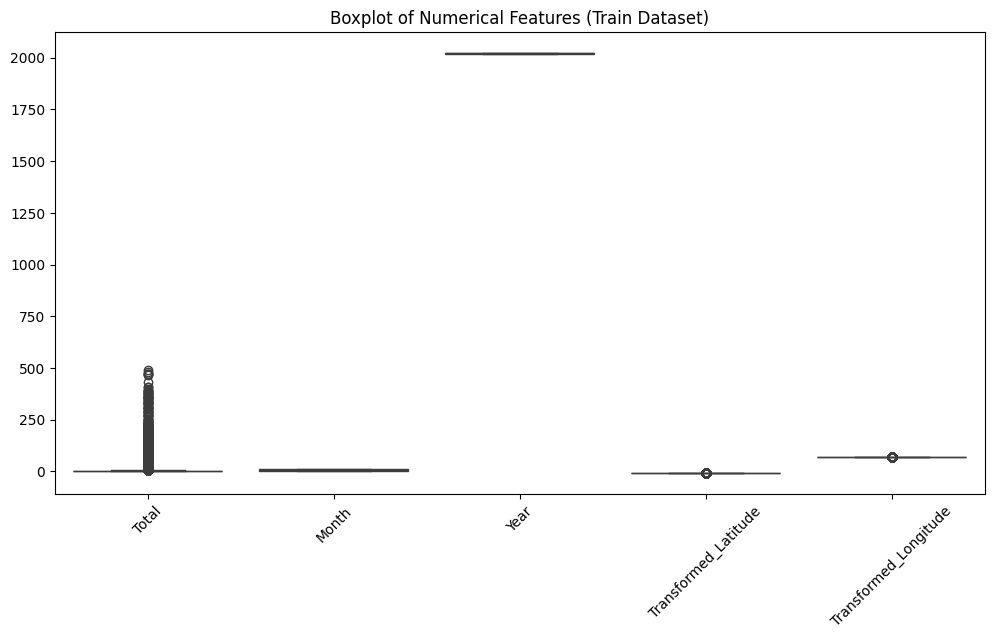

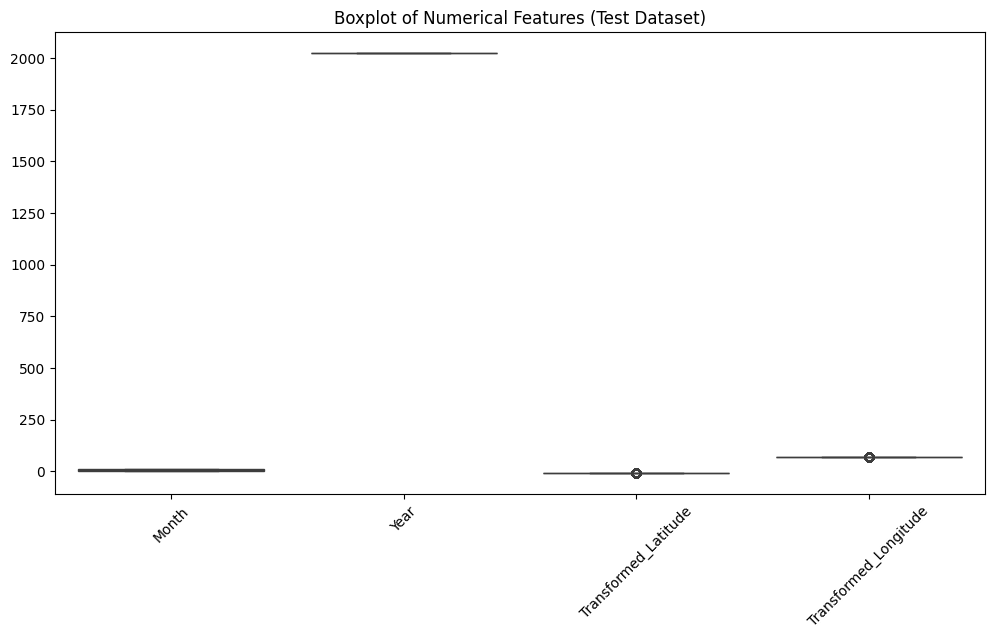

In [10]:
# Function to plot boxplots for numerical features
def plot_boxplots(df, title):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df.select_dtypes(include=['number']))
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()

# Boxplots
plot_boxplots(train, "Boxplot of Numerical Features (Train Dataset)")
plot_boxplots(test, "Boxplot of Numerical Features (Test Dataset)")


### Outliers Using IQR

In [11]:
def detect_outliers_iqr(data, multiplier=1.5):
    """Detects outliers in a given Pandas Series using the IQR method."""
    q1 = np.percentile(data.dropna(), 25)
    q3 = np.percentile(data.dropna(), 75)
    IQR = q3 - q1
    lwr_bound = q1 - (1.5 * IQR)
    upr_bound = q3 + (multiplier * IQR)

    return data[(data < lwr_bound) | (data > upr_bound)].index

#### Note: 4609 outliers out of 23,847. (19.3%).

### Summary Statistics

In [12]:
print("Train Data - Summary Stats\n")

train.describe()

Train Data - Summary Stats



,Total,Month,Year,Transformed_Latitude,Transformed_Longitude
count,23847.000000,23848.000000,23848.000000,23848.00000,23848.000000
mean,8.355600,6.568643,2020.610282,-8.61252,68.242682
std,28.076713,3.445577,1.133108,0.04251,0.029114
min,0.000000,1.000000,2019.000000,-8.71376,68.169720
25%,0.000000,4.000000,2020.000000,-8.62656,68.224740
50%,0.000000,7.000000,2021.000000,-8.61740,68.237620
75%,3.000000,10.000000,2022.000000,-8.59431,68.257640
max,489.000000,12.000000,2022.000000,-8.49681,68.328390


In [13]:
print("Test Data - Summary Stats\n")

test.describe()

Test Data - Summary Stats



,Month,Year,Transformed_Latitude,Transformed_Longitude
count,4872.000000,4872.0,4872.000000,4872.000000
mean,6.500000,2023.0,-8.609202,68.239384
std,3.452407,0.0,0.041923,0.028248
min,1.000000,2023.0,-8.713760,68.169720
25%,3.750000,2023.0,-8.626560,68.224400
50%,6.500000,2023.0,-8.617375,68.235815
75%,9.250000,2023.0,-8.591610,68.252550
max,12.000000,2023.0,-8.496810,68.328390


### Variable Distribution

In [14]:
# # Plot target variable distribution
# plt.figure(figsize=(10, 5))
# sns.histplot(train['Total'], bins=30, kde=True)
# plt.title("Distribution of Total Variable")
# plt.show()

### Correlation in Train Data

In [15]:
# # Select only numeric columns
# numeric_cols = train.select_dtypes(include=['number'])

# # Compute correlation only for numeric features
# plt.figure(figsize=(12, 6))
# sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title("Feature Correlation Heatmap")
# plt.show()


# Preprocessing

### Missing Values

In [16]:
# Imputing with Median
train.loc[:, 'Total'] = train['Total'].fillna(train['Total'].median())

# Number of Missing Values
train.isnull().sum()

ID                               0
Total                            0
Location                         0
Category_Health_Facility_UUID    0
Disease                          0
Month                            0
Year                             0
Transformed_Latitude             0
Transformed_Longitude            0
dtype: int64

### Duplicates, Skewness and Outliers

In [17]:
train_with_duplicates = train.copy()

In [18]:
# Log_Total before detecting outliers
train_with_duplicates["Log_Total"] = np.log1p(train_with_duplicates["Total"])

train_with_duplicates["Z_Score_Total"] = np.abs(zscore(train_with_duplicates["Total"]))
train_with_duplicates["Z_Score_Log_Total"] = np.abs(zscore(train_with_duplicates["Log_Total"]))

### Outlier Detection Before Removing Duplicates

In [19]:
# Using IQR
outliers_iqr_with_duplicates = train_with_duplicates.loc[detect_outliers_iqr(train_with_duplicates["Total"])]
outliers_iqr_log_with_duplicates = train_with_duplicates.loc[detect_outliers_iqr(train_with_duplicates["Log_Total"])]


# Using Z-score
outliers_zscore_with_duplicates = train_with_duplicates.loc[train_with_duplicates["Z_Score_Total"] > 3]
outliers_zscore_log_with_duplicates = train_with_duplicates.loc[train_with_duplicates["Z_Score_Log_Total"] > 3]


### Removing Duplicates

In [20]:
# Drop duplicate rows
train = train.drop_duplicates()

### Outlier Detection After Removing Duplicates

In [21]:
# Log_Total after dropping duplicates
train["Log_Total"] = np.log1p(train["Total"])

train["Z_Score_Total"] = np.abs(zscore(train["Total"]))
train["Z_Score_Log_Total"] = np.abs(zscore(train["Log_Total"]))

In [22]:
# Detect outliers using IQR on Total and Log_Total after dropping duplicates
outliers_iqr_no_duplicates = train.loc[detect_outliers_iqr(train["Total"])]
outliers_iqr_log_no_duplicates = train.loc[detect_outliers_iqr(train["Log_Total"])]


# Detect outliers using Z-score on Total and Log_Total after dropping duplicates
outliers_zscore_no_duplicates = train.loc[train["Z_Score_Total"] > 3]
outliers_zscore_log_no_duplicates = train.loc[train["Z_Score_Log_Total"] > 3]

In [23]:
outlier_df = pd.DataFrame(
    {
        "Method": ["IQR", "Z-Score"],
        "Total_With_Duplicates": [outliers_iqr_with_duplicates.shape[0], outliers_zscore_with_duplicates.shape[0]],
        "Total_No_Duplicates": [outliers_iqr_no_duplicates.shape[0], outliers_zscore_no_duplicates.shape[0]],
        "Log_Total_With_Duplicates": [outliers_iqr_log_with_duplicates.shape[0], outliers_zscore_log_with_duplicates.shape[0]],
        "Log_Total_No_Duplicates": [outliers_iqr_log_no_duplicates.shape[0], outliers_zscore_log_no_duplicates.shape[0]]
    }
)


print("Number of Outliers With and Without Duplicates in Total and Log_Total")

outlier_df

Number of Outliers With and Without Duplicates in Total and Log_Total


,Method,Total_With_Duplicates,Total_No_Duplicates,Log_Total_With_Duplicates,Log_Total_No_Duplicates
0,IQR,4609,2355,1857,41
1,Z-Score,449,315,206,58


### Train Data Set (Review)

In [24]:
train.head()

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude,Log_Total,Z_Score_Total,Z_Score_Log_Total
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2022,-8.62982,68.23267,0.00000,0.354932,0.724124
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2022,-8.62982,68.23267,0.00000,0.354932,0.724124
2,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267,0.00000,0.354932,0.724124
5,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Schistosomiasis,12,2022,-8.62982,68.23267,0.00000,0.354932,0.724124
6,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,6.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Malaria,12,2022,-8.62982,68.23267,1.94591,0.170384,0.568363


In [25]:
# train = train.drop(["Z_Score_Total","Z_Score_Log_Total"], axis=1)
# train.head()

### Impute Outliers with Median

In [26]:
train_no_outliers = train.copy()

In [27]:
# Impute IQR outliers with median
for col in ["Total", "Log_Total"]:
    median_value = train_no_outliers[col].median()
    train_no_outliers.loc[detect_outliers_iqr(train_no_outliers[col]), col] = median_value

# Impute Z-score outliers with median
for col in ["Total", "Log_Total"]:
    median_value = train_no_outliers[col].median()
    train_no_outliers.loc[train_no_outliers[f"Z_Score_{col}"] > 3, col] = median_value


In [28]:
# Step 1: Detect Outliers Again After Imputation
outliers_iqr_after = {
    "Total": len(detect_outliers_iqr(train_no_outliers["Total"])),
    "Log_Total": len(detect_outliers_iqr(train_no_outliers["Log_Total"]))
}

outliers_zscore_after = {
    "Total": (train_no_outliers["Z_Score_Total"] > 3).sum(),
    "Log_Total": (train_no_outliers["Z_Score_Log_Total"] > 3).sum()
}

# Step 2: Create DataFrame to Compare Outliers Before and After Imputation
outliers_after_df = pd.DataFrame(
    {
        "Method": ["IQR", "Z-Score"],
        "Total_After_Imputation": [outliers_iqr_after["Total"], outliers_zscore_after["Total"]],
        "Log_Total_After_Imputation": [outliers_iqr_after["Log_Total"], outliers_zscore_after["Log_Total"]]
    }
)

# Step 3: Print Results
print("Outliers Remaining After Imputation:")
print(outliers_after_df)


Outliers Remaining After Imputation:
    Method  Total_After_Imputation  Log_Total_After_Imputation
0      IQR                    3735                          10
1  Z-Score                     315                          58


### LATER

### Skewness and Outliers

In [29]:
def detect_outliers_iqr(data, multiplier=3.5):
    """Detects outliers in a given Pandas Series using the IQR method, with an adjustable multiplier."""
    data = data.dropna()  # Remove NaN values

    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    IQR = q3 - q1
    lwr_bound = q1 - (1.5 * IQR)  # Keep lower bound strict
    upr_bound = q3 + (multiplier * IQR)  # Adjust upper bound using multiplier

    return data[(data < lwr_bound) | (data > upr_bound)].index

# Apply Log Transformation
train["Log_Total"] = np.log1p(train["Total"])  # log1p prevents log(0) errors

# Detect outliers on log-transformed data with the corrected function
outlier_indices = detect_outliers_iqr(train["Log_Total"], multiplier=1.5) 

In [30]:
train["Log_Z_Score"] = np.abs(zscore(train["Log_Total"]))  # Compute absolute Z-score
outlier_indices_z = train[train["Log_Z_Score"] > 3].index  # Use threshold of 3
outliers_indices_z_normal = train_with_duplicates[train_with_duplicates["Total"] > 3].index

print(f"Number of outliers using Z-score method on original Total (with duplicates): {len(outliers_indices_z_normal)}\n")
print(f"Number of outliers using Z-score method on Log_Total (no duplicates): {len(outlier_indices_z)}")


Number of outliers using Z-score method on original Total (with duplicates): 5790

Number of outliers using Z-score method on Log_Total (no duplicates): 58


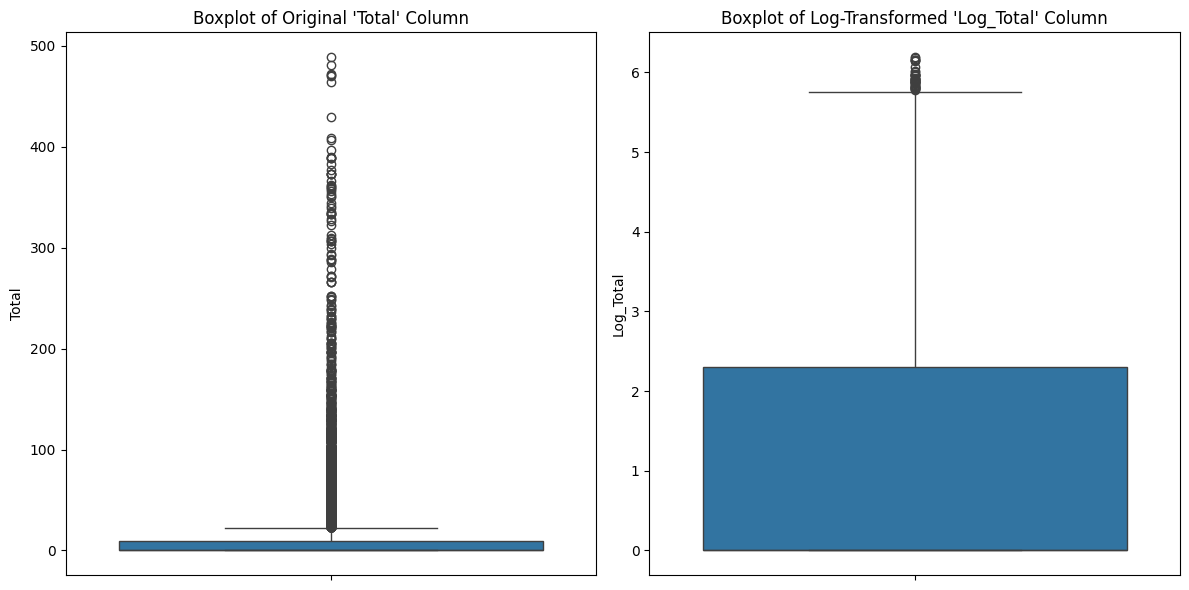

In [31]:
def plot_boxplot_comparison(df, original_col, transformed_col):
    """Plots side-by-side boxplots for original and log-transformed columns."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Boxplot for Original "Total" column
    sns.boxplot(y=df[original_col], ax=axes[0])
    axes[0].set_title(f"Boxplot of Original '{original_col}' Column")
    axes[0].set_ylabel(original_col)

    # Boxplot for Log-Transformed "Total" column
    sns.boxplot(y=df[transformed_col], ax=axes[1])
    axes[1].set_title(f"Boxplot of Log-Transformed '{transformed_col}' Column")
    axes[1].set_ylabel(transformed_col)

    plt.tight_layout()
    plt.show()

# Call the function to compare original and log-transformed Total column
plot_boxplot_comparison(train, "Total", "Log_Total")

Removing the duplicates significantly removed the outliers.

### Original Starter

In [32]:
# Combine train and test datasets for consistent preprocessing
hospital_data = pd.concat([train, test])

In [33]:
# Drop unnecessary columns from supplementary datasets
for df in [toilets, waste_management, water_sources]:
    df.drop(columns=['Year', 'Month'], inplace=True)

In [34]:
# Rename columns for clarity
def rename_columns(df, prefix):
    for col in df.columns:
        if col not in ['Month_Year_lat_lon', 'lat_lon']:
            df.rename(columns={col: f"{prefix}_{col}"}, inplace=True)

rename_columns(toilets, "toilet")
rename_columns(waste_management, "waste")
rename_columns(water_sources, "water")


In [35]:
# Fill missing values in the 'Total' column
hospital_data['Total'].fillna(0, inplace=True)

/tmp/ipykernel_177473/3418388177.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hospital_data['Total'].fillna(0, inplace=True)


In [36]:
# Drop rows with missing latitude and longitude in water sources
water_sources.dropna(subset=['water_Transformed_Latitude'], inplace=True)

In [37]:
# Visualize locations for a specific year and month
# Note the months/year should in the given timeframe [2019, 2023]
def plot_locations(year=2022, month=1, month_name='January'):
    if year < 2019 or year > 2023:
        print("Invalid year. Please choose a year between 2019 and 2023.")
        return

    if month < 1 or month > 12:
        print("Invalid month. Please choose a month between 1 and 12.")
        return

    if month_name.capitalize() not in ['January', 'February', 'March',
                                       'April', 'May', 'June', 'July',
                                       'August', 'September', 'October',
                                       'November', 'December']:
        print("Invalid month name. Please choose from 'January' to 'December'.")
        return

    plt.figure(figsize=(12, 8))
    subsets = [
        (hospital_data.query(f"Year == {year} and Month == {month}"), 'Transformed', 'Hospital', 's'),
        (water_sources.query(f"water_Month_Year == '{month}_{year}'"), 'water_Transformed', 'Water', 'o'),
        (waste_management.query(f"waste_Month_Year == '{month}_{year}'"), 'waste_Transformed', 'Waste', 'x'),
        (toilets.query(f"toilet_Month_Year == '{month}_{year}'"), 'toilet_Transformed', 'Toilet', '^'),
    ]
    for df, prefix, label, marker in subsets:
        plt.scatter(df[f'{prefix}_Longitude'], df[f'{prefix}_Latitude'], label=label, alpha=0.6, marker=marker)
    plt.title(f'Locations ({month_name.capitalize()} {year})')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.grid(True)
    plt.show()

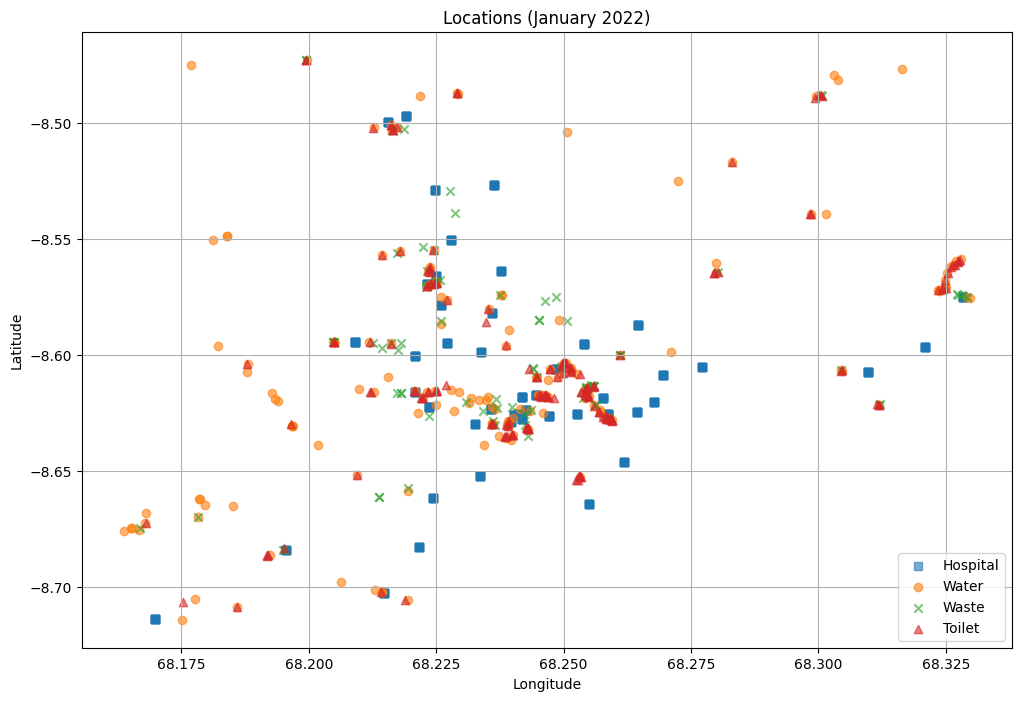

In [38]:
plot_locations()

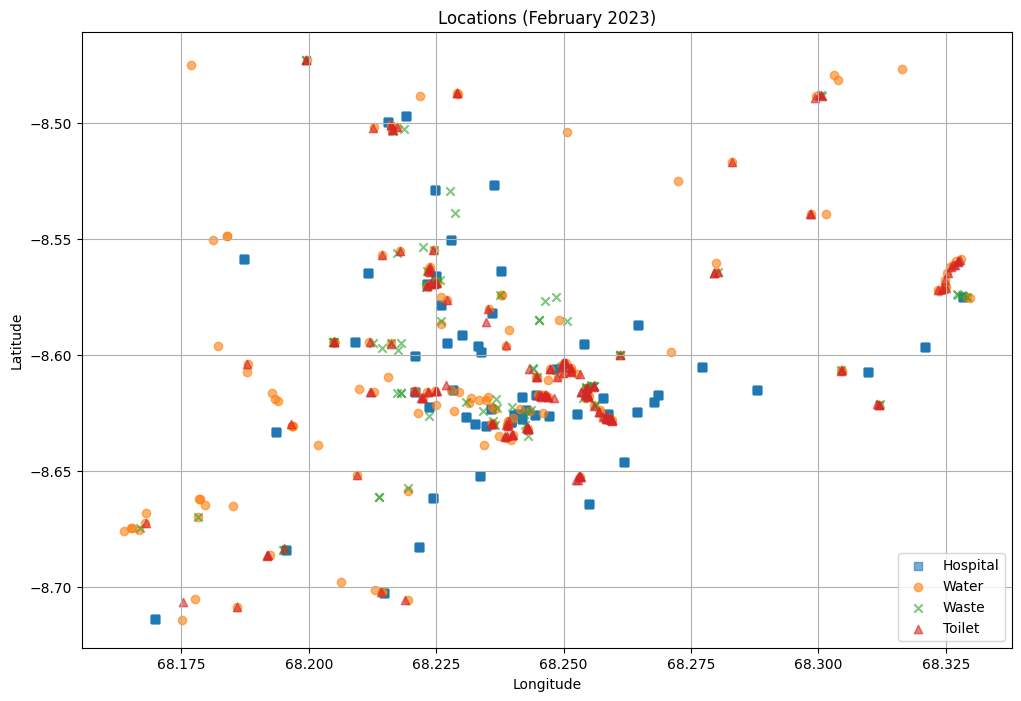

In [39]:
plot_locations(year=2023, month=2, month_name='February')

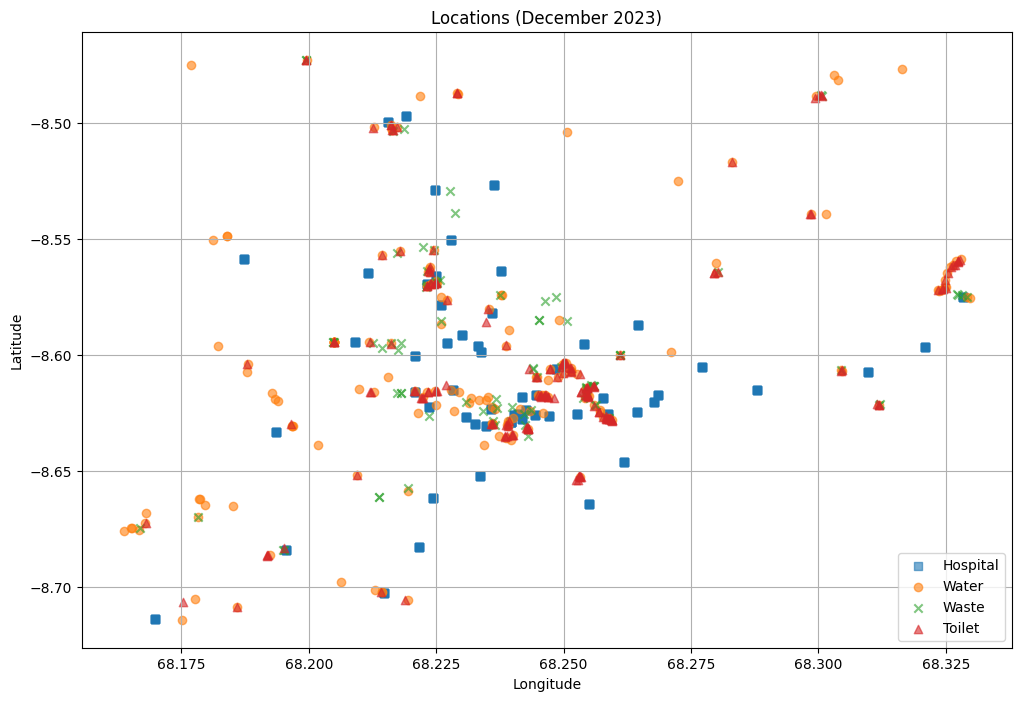

In [40]:
plot_locations(year=2023, month=12, month_name='December')

In [41]:
plot_locations(year=2000, month=1, month_name='January')

Invalid year. Please choose a year between 2019 and 2023.


In [42]:
def find_nearest(hospital_df, location_df, lat_col, lon_col, id_col):
    # Create a cKDTree for efficient nearest neighbour search
    tree = cKDTree(location_df[[lat_col, lon_col]].values)
    nearest = {}
    # Loop through each hospital and find the nearest site in location_df
    for _, row in hospital_df.iterrows():
        _, idx = tree.query([row['Transformed_Latitude'], row['Transformed_Longitude']])
        nearest[row['ID']] = location_df.iloc[idx][id_col]
    return nearest


In [43]:
# Ensure unique identifier columns exist in all supplementary datasets
for df, prefix in [(toilets, 'toilet'), (waste_management, 'waste'), (water_sources, 'water')]:
    df[f"{prefix}_Month_Year_lat_lon"] = (
        df[f"{prefix}_Month_Year"] + '_' +
        df[f"{prefix}_Transformed_Latitude"].astype(str) + '_' +
        df[f"{prefix}_Transformed_Longitude"].astype(str)
    )

In [44]:
toilets.head()

,toilet_10u,toilet_10v,toilet_2d,toilet_2t,toilet_evabs,toilet_evaow,toilet_evatc,toilet_evavt,toilet_albedo,toilet_lshf,...,toilet_swvl1,toilet_swvl2,toilet_swvl3,toilet_swvl4,toilet_Transformed_Latitude,toilet_Transformed_Longitude,toilet_Month_Year,lat_lon,Month_Year_lat_lon,toilet_Month_Year_lat_lon
0,-1.006850,-0.714544,293.502,297.417,-0.002489,-0.001031,-0.000989,-3.445890e-08,0.173221,0.650001,...,0.346542,0.335724,0.264359,0.300018,-8.61768,68.24536,1_2019,-8.61768_68.24536,1_2019_-8.61768_68.24536,1_2019_-8.61768_68.24536
1,-1.408560,-0.662555,292.943,297.978,-0.002556,-0.001076,-0.000734,-3.818420e-08,0.173808,0.650001,...,0.254517,0.259918,0.281769,0.296188,-8.61768,68.24536,2_2019,-8.61768_68.24536,2_2019_-8.61768_68.24536,2_2019_-8.61768_68.24536
2,-0.892110,-0.449448,293.250,297.989,-0.002535,-0.000980,-0.000713,-3.678720e-08,0.178823,0.650001,...,0.278152,0.284195,0.261597,0.291672,-8.61768,68.24536,3_2019,-8.61768_68.24536,3_2019_-8.61768_68.24536,3_2019_-8.61768_68.24536
3,-0.392348,0.384925,293.934,296.542,-0.001748,-0.000658,-0.001343,-2.700840e-08,0.180959,0.650017,...,0.385513,0.378616,0.309784,0.288925,-8.61768,68.24536,4_2019,-8.61768_68.24536,4_2019_-8.61768_68.24536,4_2019_-8.61768_68.24536
4,-0.447104,0.581028,292.571,294.726,-0.001374,-0.000462,-0.001139,-2.048910e-08,0.182375,0.650009,...,0.397659,0.400055,0.392654,0.309311,-8.61768,68.24536,5_2019,-8.61768_68.24536,5_2019_-8.61768_68.24536,5_2019_-8.61768_68.24536


In [45]:
# Merge datasets with nearest locations
merged_data = hospital_data.copy()
datasets = [
    (toilets, 'toilet', 'toilet_Month_Year_lat_lon'),
    (waste_management, 'waste', 'waste_Month_Year_lat_lon'),
    (water_sources, 'water', 'water_Month_Year_lat_lon'),
]

In [46]:
for df, prefix, id_col in datasets:
    nearest = find_nearest(merged_data, df, f"{prefix}_Transformed_Latitude", f"{prefix}_Transformed_Longitude", id_col)
    nearest_df = pd.DataFrame(list(nearest.items()), columns=['ID', id_col])
    merged_data = merged_data.merge(nearest_df, on="ID").merge(df, on=id_col)

In [47]:
merged_data.shape

(22520, 139)

In [48]:
merged_data.head(2)

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude,Log_Total,...,water_tp,water_swvl1,water_swvl2,water_swvl3,water_swvl4,water_Transformed_Latitude,water_Transformed_Longitude,water_Month_Year,lat_lon,Month_Year_lat_lon
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2022,-8.62982,68.23267,0.0,...,0.002667,0.325867,0.325302,0.281708,0.24585,-8.62966,68.23589,12_2023,-8.62966_68.23589,12_2023_-8.62966_68.23589
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2022,-8.62982,68.23267,0.0,...,0.002667,0.325867,0.325302,0.281708,0.24585,-8.62966,68.23589,12_2023,-8.62966_68.23589,12_2023_-8.62966_68.23589


## Start modeling

In [49]:
# Split merged data into train and test sets
train_df = merged_data[merged_data['Year'] < 2023]
test_df = merged_data[merged_data['Year'] == 2023]

In [50]:
# Specify the target column
target_column = 'Total'

# Feature and target split
X = train_df.drop(columns=[target_column, 'ID', 'Location'])  # Exclude unnecessary columns
y = train_df[target_column]

In [51]:
# Handle categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])


In [52]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
# Initialize and train the regression model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [54]:
# Make predictions
y_pred = model.predict(X_test)

In [55]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.], shape=(3513,))

In [56]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 0.01961855963563911


#### Make predictions on test

In [57]:
# Prepare test data
X_test_final = test_df.drop(columns=['Total', 'ID', 'Location'], errors='ignore')

In [58]:
# Handle categorical features in test data
for col in categorical_cols:
    if col in X_test_final.columns:
        le = LabelEncoder()
        X_test_final[col] = le.fit_transform(X_test_final[col])

In [59]:
# Align test dataset with training features
for col in X.columns:
    if col not in X_test_final.columns:
        X_test_final[col] = 0  # Add missing feature with default value (e.g., zero)


In [60]:
# Ensure columns are in the same order as training
X_test_final = X_test_final[X.columns]

In [61]:
# Make predictions on test data
predictions = model.predict(X_test_final)

In [62]:
# Create the final DataFrame with ID and predictions
sub = test_df[['ID']].copy()
sub['Predicted_Total'] = predictions

In [63]:
# View the first few records in sub
sub.head()

,ID,Predicted_Total
17564,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_1_2023...,0.0
17565,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_2_2023...,0.0
17566,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_3_2023...,0.0
17567,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_4_2023...,0.0
17568,ID_00cd8292-dd85-4fa3-8148-9592e88a1651_5_2023...,0.0


In [64]:
# Save the final DataFrame to a CSV
sub.to_csv(data_dir / 'Benchmark.csv', index=False)